In [1]:
! git clone https://github.com/dylkot/scsim.git
! mv scsim ../..

fatal: destination path 'scsim' already exists and is not an empty directory.
mv: cannot move 'scsim' to '../../scsim': Directory not empty


## Run scsim simulator

In [2]:
! python ../../scsim/run_scsim.py -h

usage: run_scsim.py [-h] [--outdir OUTDIR] [--seed SEED] [--numsims NUMSIMS]
                    [--deloc DELOC] [--K K] [--nproggoups NPROGGOUPS]
                    [--ncells NCELLS] [--doubletfrac DOUBLETFRAC]

Run scsim with specified input arguments

optional arguments:
  -h, --help            show this help message and exit
  --outdir OUTDIR       Output directory base
  --seed SEED           simulation seed
  --numsims NUMSIMS     number of sims to run
  --deloc DELOC         devalue
  --K K                 Number of identity programs
  --nproggoups NPROGGOUPS
                        Number of groups expressing activity program. Default
                        is 1/3 of K rounded down
  --ncells NCELLS       Total number of cells
  --doubletfrac DOUBLETFRAC
                        Percentage of doublet cells


In [3]:
! mkdir ./example_data

In [4]:
! python ../../scsim/run_scsim.py --outdir ./example_data --seed 14 --numsims 1 --K 6 --nproggoups 3 --ncells 2500 --doubletfrac .05 --deloc 1.5

Simulating cells
Simulating gene params
Simulating program
Simulating DE
Simulating cell-gene means
   - Getting mean for activity program carrying cells
   - Getting mean for non activity program carrying cells
   - Normalizing by cell libsize
Simulating doublets
/mnt/disks/seqwell/update_cnmf/scsim/scsim.py:103: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  group2 = self.cellparams.ix[extraind, 'group'].values
/opt/miniconda3/envs/py37_2/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
Adjusting means
Simulating counts

## Filter out cells or genes with too few counts

In [5]:
%matplotlib inline
import sys
sys.path.append('..')
from cnmf import load_df_from_npz, get_highvar_genes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from bhtsne import tsne
import palettable
import matplotlib.gridspec as gridspec

In [6]:
counts = load_df_from_npz('./example_data/counts.npz')
counts.head()

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene9991,Gene9992,Gene9993,Gene9994,Gene9995,Gene9996,Gene9997,Gene9998,Gene9999,Gene10000
Cell1,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
Cell2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Cell4,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,1,0,0,0,5,0
Cell5,0,0,1,0,4,0,0,0,0,1,...,0,0,0,0,0,4,0,0,0,0


In [7]:
gene_thresh = (counts.shape[0]*.005) # only keep genes detected in 1/200 cells
keep_gene_ind = (counts>0).sum(axis=0)>gene_thresh
counts = counts.loc[:,keep_gene_ind]

Text(0.5, 0, 'log10 Counts Per Cell')

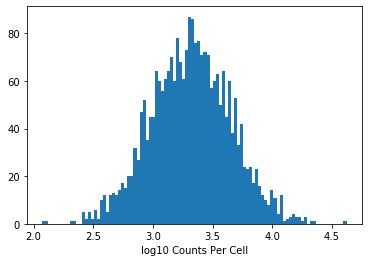

In [8]:
_ = plt.hist(counts.sum(axis=1).apply(np.log10), bins=100)
plt.xlabel('log10 Counts Per Cell')

In [9]:
counts.to_csv('./example_data/filtered_counts.txt', sep='\t')

In [10]:
cellparams = load_df_from_npz('./example_data/cellparams.npz')
cellparams.head()

,group,libsize,has_program,program_usage,is_doublet,group2
Cell1,4,2623.12,False,0,False,-1
Cell2,5,1623.83,False,0,False,-1
Cell3,6,2222.49,False,0,False,-1
Cell4,1,3213.6,True,0.262699,False,-1
Cell5,2,2396.51,True,0.127641,False,-1


In [11]:
cellparams.to_csv('./example_data/groundtruth_cellparams.txt', sep='\t')

In [12]:
cellparams['group'].value_counts()

3    438
4    436
6    423
2    420
1    392
5    391
Name: group, dtype: int64

In [13]:
pd.crosstab(cellparams['group'], cellparams['has_program'])

has_program,False,True
group,,
1,250,142
2,284,136
3,281,157
4,436,0
5,391,0
6,423,0


In [14]:
geneparams = load_df_from_npz('./example_data/geneparams.npz')
geneparams.head()

,BaseGeneMean,is_outlier,outlier_ratio,gene_mean,prog_gene,prog_genemean,group1_DEratio,group1_genemean,group2_DEratio,group2_genemean,group3_DEratio,group3_genemean,group4_DEratio,group4_genemean,group5_DEratio,group5_genemean,group6_DEratio,group6_genemean
Gene1,0.0988507,False,1,0.0988507,False,0.0988507,1,0.0988507,1,0.0988507,2.46913,0.244075,1,0.0988507,1,0.0988507,1,0.0988507
Gene2,0.00212113,False,1,0.00212113,False,0.00212113,1,0.00212113,1,0.00212113,1,0.00212113,1,0.00212113,1,0.00212113,1,0.00212113
Gene3,0.0188191,False,1,0.0188191,False,0.0188191,1,0.0188191,1,0.0188191,1,0.0188191,1,0.0188191,1,0.0188191,1,0.0188191
Gene4,1.59237e-05,False,1,1.59237e-05,False,1.59237e-05,1,1.59237e-05,1,1.59237e-05,1,1.59237e-05,1,1.59237e-05,1,1.59237e-05,1,1.59237e-05
Gene5,0.1097,False,1,0.1097,False,0.1097,1,0.1097,1,0.1097,1,0.1097,1,0.1097,1,0.1097,1,0.1097


In [15]:
geneparams.to_csv('./example_data/groundtruth_geneparams.txt', sep='\t')

In [16]:
! ls ./example_data/

cellparams.npz	filtered_counts.txt  groundtruth_cellparams.txt
counts.npz	geneparams.npz	     groundtruth_geneparams.txt


In [17]:
! rm ./example_data/geneparams.npz
! rm ./example_data/cellparams.npz

In [18]:
! ls ./example_data/

counts.npz	     groundtruth_cellparams.txt
filtered_counts.txt  groundtruth_geneparams.txt


In [19]:
TPM = counts.div(counts.sum(axis=1), axis=0) * (10**6)

(gene_counts_stats, gene_fano_parameters) = get_highvar_genes(TPM.values, numgenes=2000)


TPM_hvgs = TPM.iloc[:,gene_counts_stats.high_var.values]

## And run PCA
PCs = PCA(n_components=10).fit_transform(preprocessing.scale(TPM_hvgs))
PCs = pd.DataFrame(PCs, index=TPM_hvgs.index, columns=['PC%d' % i for i in range(1,11)])
PCs.head()

## And run tSNE
tsne_results = pd.DataFrame(tsne(PCs.values), index=PCs.index, columns=['TSNE1', 'TSNE2'])
tsne_results.to_csv('./example_data/tsne.txt', sep='\t')

In [20]:
tsnedat = pd.merge(left=tsne_results, right=cellparams, left_index=True, right_index=True)

tsnedat['extra-status'] = 'Normal'
tsnedat.loc[tsnedat['has_program'] & ~tsnedat['is_doublet'], 'extra-status'] = 'program'
tsnedat.loc[~tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'doublet'
tsnedat.loc[ tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'program & doublet'

In [21]:


cell_tableau10_color_id = tsnedat['group'].astype(int).values - 1
cell_tableau10_color = np.array(palettable.tableau.Tableau_10.colors[:-1])[cell_tableau10_color_id]/255.

activity_color = np.zeros((tsnedat.shape[0], 4))
activity_color[:, 3] = tsnedat['has_program'].astype(float)
doublet_color = np.array(palettable.tableau.TableauMedium_10.colors[5])/255. 

In [22]:
normal_filter = tsnedat['extra-status'] == 'Normal'
doublet_filter = tsnedat['extra-status'] == 'doublet'
activity_filter = tsnedat['extra-status'] == 'program'
activity_and_doublet_filter = tsnedat['extra-status'] == 'program & doublet'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0, 1)

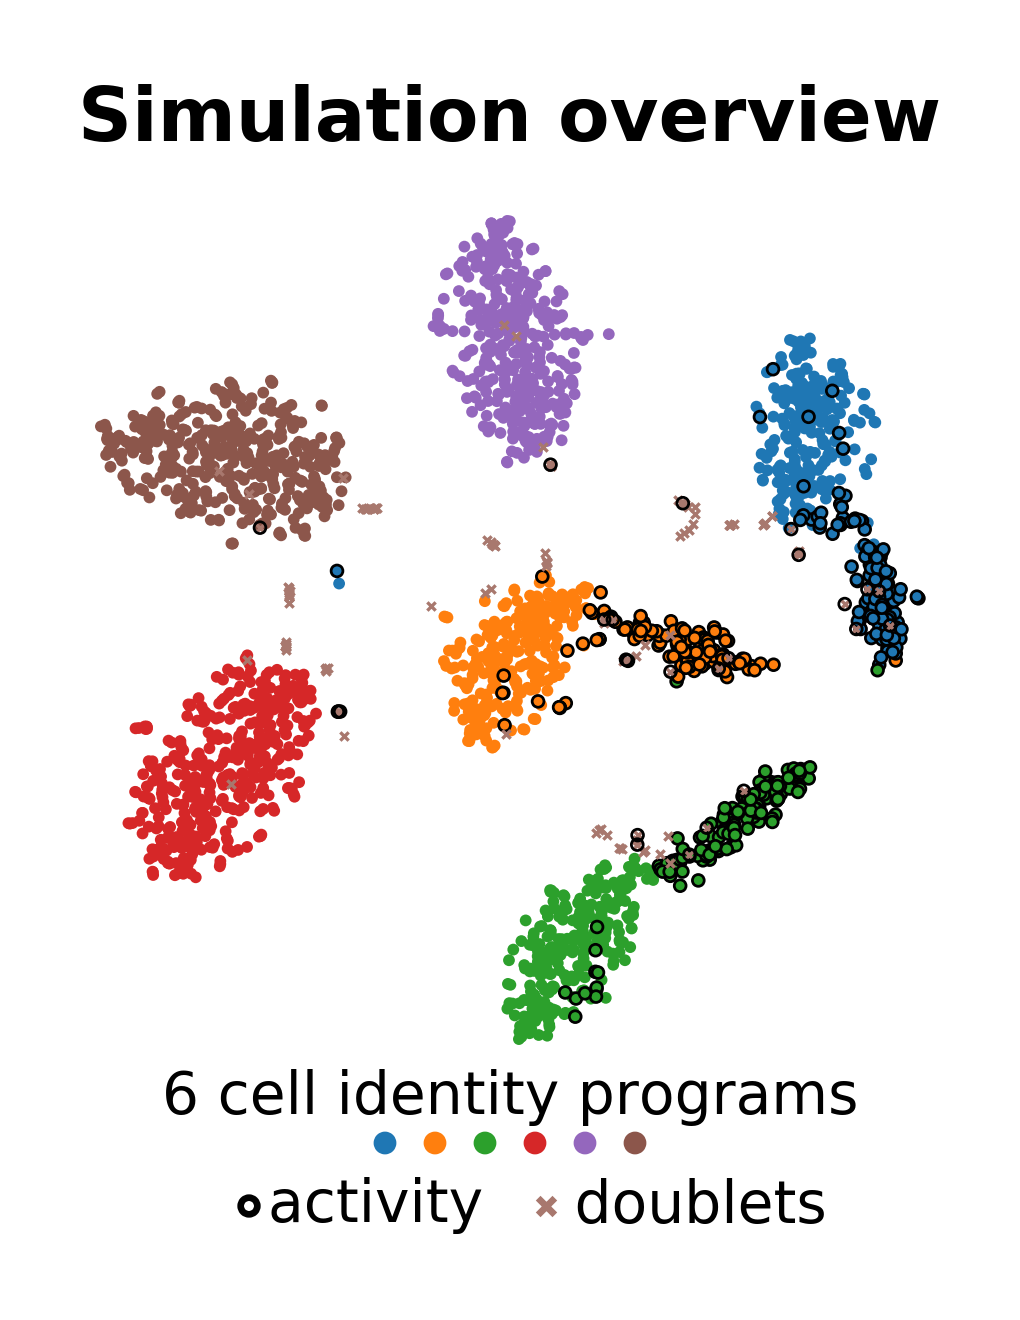

In [23]:
K = 6
fig = plt.figure(figsize=(1.5, 2), dpi=600)
gs = gridspec.GridSpec(3, 1, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       height_ratios=[0.2, 1.5, 0.3],
                       width_ratios=[1])

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[], yticks=[])

x = tsnedat['TSNE1']
y = tsnedat['TSNE2']


curr_filter = normal_filter


ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
           edgecolor='none',
           rasterized=True, s=2)

curr_filter = activity_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


curr_filter = doublet_filter | activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          c=doublet_color,
          edgecolor='none', marker='x', linewidth=0.4,
          s=1)

curr_filter = activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor='none',
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


ax = fig.add_subplot(gs[0, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.5, 'Simulation overview', va='center', ha='center', fontsize=9, fontdict=dict(weight='bold'),
        clip_on=False)


ax = fig.add_subplot(gs[2, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.9, '%d cell identity programs' % K, va='center', ha='center', fontsize=7,
        clip_on=False)

leg_x = np.arange(K)/18
leg_x -= leg_x.mean()
leg_x += 0.5

ax.scatter(leg_x, np.ones(K)*0.65, c=np.array(palettable.tableau.Tableau_10.colors[:K])/255, s=3)



activity_y = 0.30
ax.text(0.33, activity_y, '  activity', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.21], [activity_y], 
           facecolor='none', edgecolor='k', linewidth=0.8, s=4)


doub_y = activity_y
ax.text(0.66, doub_y, '     doublets', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.54], [doub_y], c=[doublet_color],
           edgecolor='none', marker='x', linewidth=0.8, s=4, clip_on=False)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

In [3]:
! mv example_data simulated_example_data 

In [4]:
! tar -czvf example_data_20191024.tar.gz ./simulated_example_data/*

./simulated_example_data/counts.npz
./simulated_example_data/filtered_counts.txt
./simulated_example_data/groundtruth_cellparams.txt
./simulated_example_data/groundtruth_geneparams.txt
./simulated_example_data/tsne.txt
